# Parsing results notebook

Selecting devices...

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="4"

Imports...

In [2]:
import sys
sys.path.insert(1, "..")
from datasets.ssl_dataset import SSL_Dataset
from datasets.data_utils import get_data_loader
import matplotlib.pyplot as plt
import torch
from glob import glob
from utils import net_builder
from train_utils import mcc
import pandas as pd
from tqdm import tqdm

Loading dataset...

In [3]:
dataset_dir="/home/gabrielemeoni/project/END2END/MSMatch/data/"
test_dset = SSL_Dataset(name="thraws_swir_test", train=False, data_dir=dataset_dir)

test_dset_basic = test_dset.get_dset()
num_classes = test_dset.num_classes
num_channels = test_dset.num_channels
eval_loader = get_data_loader(test_dset_basic, 8, num_workers=1)
    

100%|█████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.42it/s]


Checkpoint path...

In [4]:
checkpoint_paths=["/home/gabrielemeoni/project/END2END/MSMatch/checkpoints/final_train_supervised", "/home/gabrielemeoni/project/END2END/MSMatch/checkpoints/final_train_supervised_no_weights", "/home/gabrielemeoni/project/END2END/MSMatch/checkpoints/final_training_msmatch_trained"]

Checking various checkpoints....

In [5]:
checkpoints_names_list=[]
checkpoint_results_list=[]
for checkpoint_path in tqdm(checkpoint_paths, desc="Checking checkpoint"):  
    checkpoints_names_list.append(checkpoint_path.split(os.sep)[-1])
    test_checkpoint_seed_paths=sorted(glob(os.path.join(checkpoint_path, "*")))
    seeds=[]
    test_results_mcc_seed=[]
    test_results_acc_seed=[]

    for test_seed_path in tqdm(test_checkpoint_seed_paths, desc="Processing seed..."):
        seeds.append(int(test_seed_path.split(os.sep)[-1].split("_")[-1]))
        upsampling_values_test_paths=sorted(glob(os.path.join(test_seed_path, "*")))
        test_results_acc_seed_upsample=[]
        test_results_mcc_seed_upsample=[]
        upsampling_values=[]
        for test in upsampling_values_test_paths:
            upsampling_values.append(int(test.split("_{")[1].split("}")[0]))

            #Exploring the whole path until you reach the final directory
            while(len(glob(os.path.join(test, "*"))) == 1):
                test=os.path.join(test, glob(os.path.join(test, "*"))[0])

            checkpoint_path = os.path.join(test, "model_best.pth")
            checkpoint = torch.load(checkpoint_path)
            load_model = (checkpoint["eval_model"])

            _net_builder = net_builder(
                "efficientnet-lite0",
                False,
                {
                    "depth": 28,
                    "widen_factor": 2,
                    "leaky_slope": 0.1,
                    "dropRate": 0.0,
                },
            )
            net = _net_builder(num_classes=num_classes, in_channels=num_channels)
            net.load_state_dict(load_model)
            if torch.cuda.is_available():
                net.cuda()
            net.eval()

            acc = 0.0
            y_true=[]
            y_pred=[]
            n=0
            with torch.no_grad():
                for image, target in eval_loader:
                    image = image.type(torch.FloatTensor).cuda()
                    logit = net(image)
                    y_pred+=list(logit.cpu().max(1)[1])
                    y_true+=list(target)
                    acc += logit.cpu().max(1)[1].eq(target).sum().numpy()

                    if n == 0:
                            pred=logit
                            correct=target
                            n+=1
                    else:
                        pred=torch.cat((pred, logit), axis=0)
                        correct=torch.cat((correct, target), axis=0)
            test_results_acc_seed_upsample.append(acc / len(test_dset_basic))
            test_results_mcc_seed_upsample.append(mcc(pred, correct))

        upsampling_values=["up_" + str(upsampling_value) for upsampling_value in upsampling_values]
        test_results_acc_seed.append(dict(zip(upsampling_values, test_results_acc_seed_upsample)))
        test_results_mcc_seed.append(dict(zip(upsampling_values, test_results_mcc_seed_upsample)))

    seeds_sorted_idx=sorted(range(len(seeds)),key=seeds.__getitem__)
    seeds_sorted=["seed_"+str(seeds[n]) for n in seeds_sorted_idx]
    test_results_acc_seed_sorted=[test_results_acc_seed[n] for n in seeds_sorted_idx]
    test_results_mcc_seed_sorted=[test_results_mcc_seed[n] for n in seeds_sorted_idx]

    tests_results_acc_dict=dict(zip(seeds_sorted, test_results_acc_seed_sorted))
    tests_results_mcc_dict=dict(zip(seeds_sorted, test_results_mcc_seed_sorted))
    checkpoint_results_list.append({"acc" : tests_results_acc_dict, "mcc" : tests_results_mcc_dict})
checkpoints_results_dict=dict(zip(checkpoints_names_list, checkpoint_results_list))

Processing seed...:   0%|                                                                             | 0/5 [00:00<?, ?it/s]

Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...



Processing seed...:  20%|█████████████▊                                                       | 1/5 [00:07<00:31,  7.83s/it]

Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...



Processing seed...:  40%|███████████████████████████▌                                         | 2/5 [00:13<00:18,  6.33s/it]

Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...



Processing seed...:  60%|█████████████████████████████████████████▍                           | 3/5 [00:18<00:11,  5.84s/it]

Using not pretrained model efficientnet-lite0 ...


/home/gabrielemeoni/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...



Processing seed...:  80%|███████████████████████████████████████████████████████▏             | 4/5 [00:23<00:05,  5.65s/it]

Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...



Processing seed...:   0%|                                                                             | 0/5 [00:00<?, ?it/s]

Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...



Processing seed...:  20%|█████████████▊                                                       | 1/5 [00:05<00:21,  5.28s/it]

Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...



Processing seed...:  40%|███████████████████████████▌                                         | 2/5 [00:10<00:15,  5.32s/it]

Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...



Processing seed...:  60%|█████████████████████████████████████████▍                           | 3/5 [00:15<00:10,  5.32s/it]

Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...



Processing seed...:  80%|███████████████████████████████████████████████████████▏             | 4/5 [00:21<00:05,  5.28s/it]

Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...



Processing seed...:   0%|                                                                             | 0/4 [00:00<?, ?it/s]

Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...



Processing seed...:  25%|█████████████████▎                                                   | 1/4 [00:05<00:16,  5.37s/it]

Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...



Processing seed...:  50%|██████████████████████████████████▌                                  | 2/4 [00:10<00:10,  5.32s/it]

Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...



Processing seed...:  75%|███████████████████████████████████████████████████▊                 | 3/4 [00:15<00:05,  5.33s/it]

Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...
Using not pretrained model efficientnet-lite0 ...



Checking checkpoint: 100%|████████████████████████████████████████████████████████████████████| 3/3 [01:17<00:00, 25.75s/it]


## Supervised training (weighted) results

### Accuracy results.

In [6]:
acc_df_supervised_weighted=pd.DataFrame.from_dict(checkpoints_results_dict["final_train_supervised"]["acc"], orient='index',columns=upsampling_values)
acc_df_supervised_weighted

,up_2,up_3,up_4,up_6,up_7
seed_0,0.977401,0.971751,0.975518,0.973635,0.975518
seed_9,0.967985,0.984934,0.986817,0.977401,0.984934
seed_14,0.967985,0.979284,0.969868,0.983051,0.988701
seed_18,0.977401,0.986817,0.979284,0.983051,0.977401
seed_19,0.935970,0.973635,0.973635,0.979284,0.979284


### MCC results.

In [7]:
mcc_df_supervised_weighted=pd.DataFrame.from_dict(checkpoints_results_dict["final_train_supervised"]["mcc"], orient='index',columns=upsampling_values)
mcc_df_supervised_weighted

,up_2,up_3,up_4,up_6,up_7
seed_0,0.794810,0.749661,0.804634,0.792870,0.793009
seed_9,0.722322,0.868940,0.886374,0.806567,0.871218
seed_14,0.715806,0.817372,0.716170,0.856737,0.902057
seed_18,0.811457,0.886374,0.829604,0.856737,0.816867
seed_19,0.000000,0.774241,0.756259,0.829604,0.814889


## Supervised training un-weighted results

### Accuracy results.

In [8]:
acc_df_supervised_no_weighted=pd.DataFrame.from_dict(checkpoints_results_dict["final_train_supervised_no_weights"]["acc"], orient='index',columns=upsampling_values)
acc_df_supervised_no_weighted

,up_2,up_3,up_4,up_6,up_7
seed_0,0.979284,0.975518,0.969868,0.979284,0.977401
seed_9,0.064030,0.981168,0.973635,0.979284,0.977401
seed_14,0.973635,0.981168,0.984934,0.984934,0.981168
seed_18,0.064030,0.988701,0.977401,0.983051,0.983051
seed_19,0.971751,0.983051,0.975518,0.971751,0.981168


### MCC results.

In [9]:
mcc_df_supervised_no_weighted=pd.DataFrame.from_dict(checkpoints_results_dict["final_train_supervised_no_weights"]["mcc"], orient='index',columns=upsampling_values)
mcc_df_supervised_no_weighted

,up_2,up_3,up_4,up_6,up_7
seed_0,0.829604,0.787943,0.755667,0.824873,0.811457
seed_9,0.000000,0.833216,0.774241,0.820753,0.794810
seed_14,0.786267,0.831872,0.871218,0.871218,0.831872
seed_18,0.000000,0.902260,0.806567,0.853564,0.853564
seed_19,0.749661,0.851227,0.804634,0.767599,0.833216


## BEST Results

In [23]:
acc_best_df=pd.DataFrame.copy(acc_df_supervised_no_weighted)
mcc_best_df=pd.DataFrame.copy(mcc_df_supervised_no_weighted)

In [24]:
for key in ["up_2", "up_3", "up_4", "up_6", "up_7"]:
    for seed in ["seed_0", "seed_9", "seed_14", "seed_18", "seed_19"]:
        acc_best_df.loc[seed][key]=max(acc_df_supervised_no_weighted.loc[seed][key], acc_df_supervised_weighted.loc[seed][key])
        mcc_best_df.loc[seed][key]=max(mcc_df_supervised_no_weighted.loc[seed][key], mcc_df_supervised_weighted.loc[seed][key])

### Best accuracy results

In [25]:
acc_best_df

,up_2,up_3,up_4,up_6,up_7
seed_0,0.979284,0.975518,0.975518,0.979284,0.977401
seed_9,0.967985,0.984934,0.986817,0.979284,0.984934
seed_14,0.973635,0.981168,0.984934,0.984934,0.988701
seed_18,0.977401,0.988701,0.979284,0.983051,0.983051
seed_19,0.971751,0.983051,0.975518,0.979284,0.981168


In [26]:
best_acc_mean=acc_best_df.iloc[:-1].mean(axis=0)
pd.DataFrame(dict(zip(list(best_acc_mean.keys().values), list(best_acc_mean.values))), index=[0])

,up_2,up_3,up_4,up_6,up_7
0,0.974576,0.98258,0.981638,0.981638,0.983522


### Best MCC results

In [27]:
mcc_best_df

,up_2,up_3,up_4,up_6,up_7
seed_0,0.829604,0.787943,0.804634,0.824873,0.811457
seed_9,0.722322,0.868940,0.886374,0.820753,0.871218
seed_14,0.786267,0.831872,0.871218,0.871218,0.902057
seed_18,0.811457,0.902260,0.829604,0.856737,0.853564
seed_19,0.749661,0.851227,0.804634,0.829604,0.833216


In [28]:
best_mcc_mean=mcc_best_df.iloc[:-1].mean(axis=0)
pd.DataFrame(dict(zip(list(best_mcc_mean.keys().values), list(best_mcc_mean.values))), index=[0])

,up_2,up_3,up_4,up_6,up_7
0,0.787413,0.847754,0.847958,0.843396,0.859574


## MSMatch results

### Accuracy results.

In [16]:
acc_df_msmatch_weighted=pd.DataFrame.from_dict(checkpoints_results_dict["final_training_msmatch_trained"]["acc"], orient='index',columns=upsampling_values)
acc_df_msmatch_weighted

,up_2,up_3,up_4,up_6,up_7
seed_0,0.981168,0.975518,0.981168,0.977401,0.966102
seed_9,0.986817,0.983051,0.986817,0.905838,0.986817
seed_14,0.299435,0.954802,0.951036,0.977401,0.981168
seed_18,0.984934,0.981168,0.954802,0.984934,0.975518


### MCC results.

In [21]:
mcc_df_msmatch_weighted=pd.DataFrame.from_dict(checkpoints_results_dict["final_training_msmatch_trained"]["mcc"], orient='index',columns=upsampling_values)
mcc_df_msmatch_weighted

,up_2,up_3,up_4,up_6,up_7
seed_0,0.835621,0.787943,0.838892,0.811457,0.749947
seed_9,0.886374,0.851227,0.885082,0.525571,0.886374
seed_14,-0.212114,0.705878,0.503625,0.811457,0.842881
seed_18,0.868940,0.838892,0.664437,0.871218,0.804634


### Best results.

In [29]:
mcc_df_msmatch_weighted_mean=mcc_df_msmatch_weighted.iloc[:-1].mean(axis=0)
pd.DataFrame(dict(zip(list(mcc_df_msmatch_weighted_mean.keys().values), list(mcc_df_msmatch_weighted_mean.values))), index=[0])

,up_2,up_3,up_4,up_6,up_7
0,0.503294,0.781683,0.742533,0.716162,0.826401


## Checking missclassification

Checking missclassifications for the model having the best MCC. 

Path to the best model.

In [18]:
best_model_path="/home/gabrielemeoni/project/END2END/MSMatch/checkpoints/final_train_supervised/Seed_14/hyperExplore_upsTrain_{7}_upsEval_{1}/thraws_swir_train/FixMatch_archefficientnet-lite0_batch8_confidence0.95_lr0.03_uratio4_wd0.00075_wu1.0_seed14_numlabels800_optSGD/model_best.pth"

In [19]:
#Changing batch to 1
eval_loader = get_data_loader(test_dset_basic, 1, num_workers=1)
checkpoint = torch.load(best_model_path)
load_model = (checkpoint["eval_model"])

_net_builder = net_builder(
    "efficientnet-lite0",
    False,
    {
        "depth": 28,
        "widen_factor": 2,
        "leaky_slope": 0.1,
        "dropRate": 0.0,
    },
)
net = _net_builder(num_classes=num_classes, in_channels=num_channels)
net.load_state_dict(load_model)
if torch.cuda.is_available():
    net.cuda()
net.eval()

y_true=[]
y_pred=[]
x_wrong=[]
with torch.no_grad():
    for image, target in tqdm(eval_loader, desc="Checking best model..."):
        image = image.type(torch.FloatTensor).cuda()
        logit = net(image)
        
        if (logit.cpu().max(1)[1] != target):
            x_wrong.append(image)
            y_pred+=list(logit.cpu().max(1)[1])
            y_true+=list(target)

        if n == 0:
                pred=logit
                correct=target
                n+=1
        else:
            pred=torch.cat((pred, logit), axis=0)
            correct=torch.cat((correct, target), axis=0)



Using not pretrained model efficientnet-lite0 ...


Checking best model...: 100%|████████████████████████████████████████████████████████████| 531/531 [00:03<00:00, 133.98it/s]


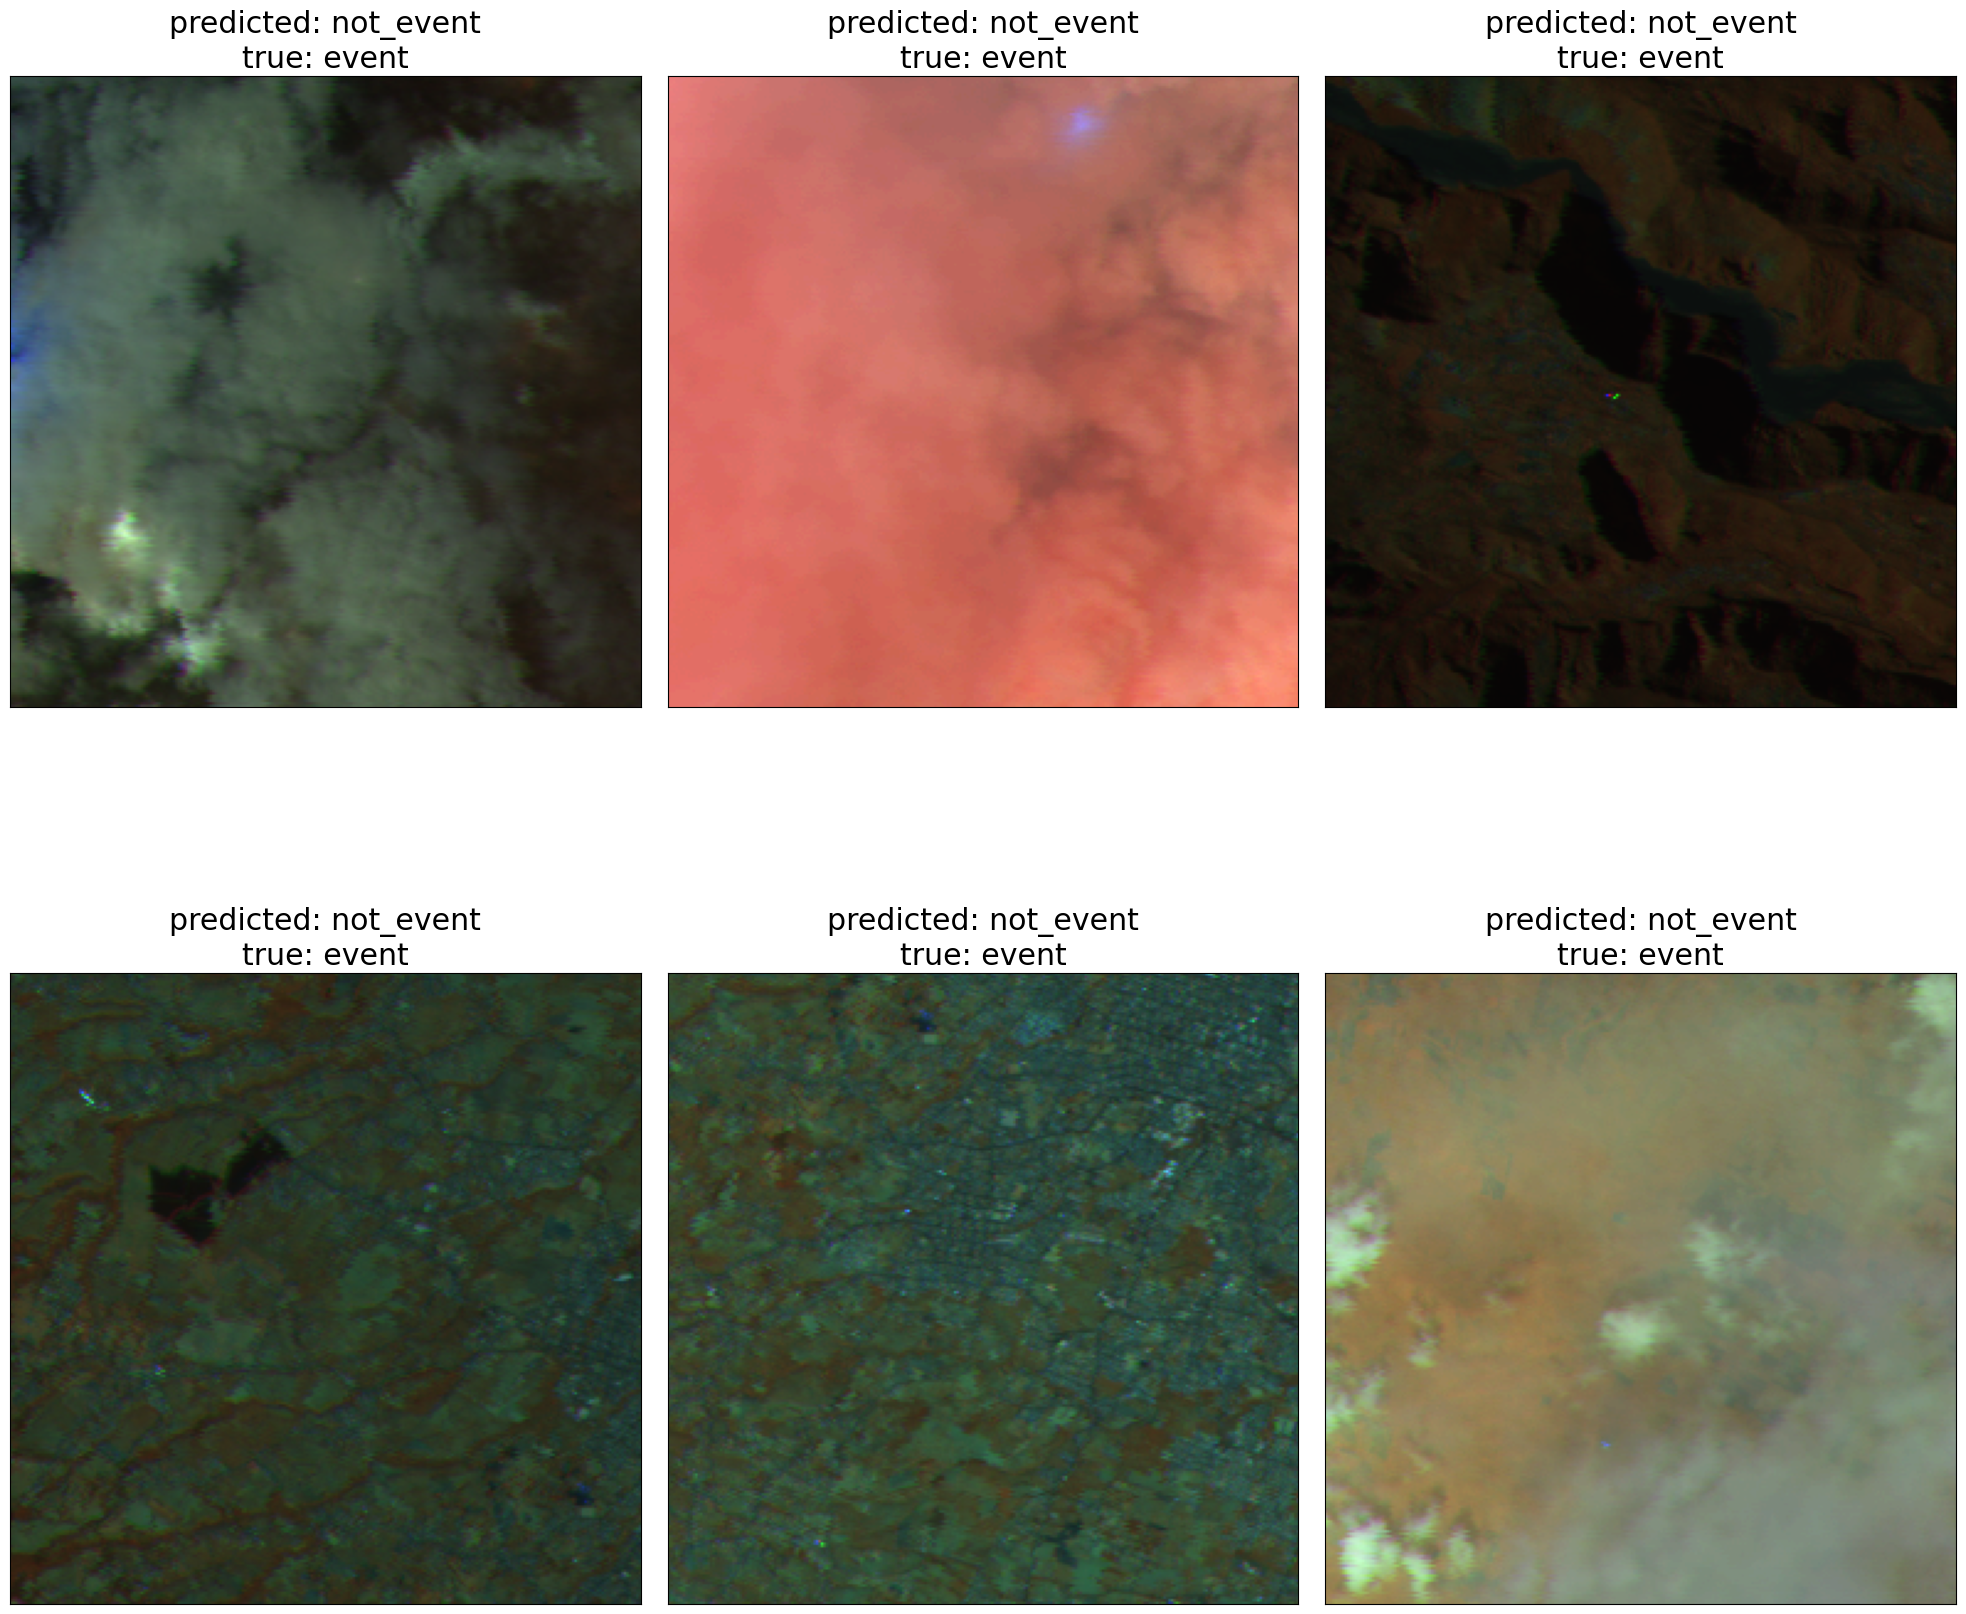

In [20]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax=plt.subplots(2,3, figsize=(20, 20))
event_dict={"0" : "event", "1" : "not_event"}

plt.rcParams.update({'font.size': 18})
for n, x in enumerate(x_wrong):
    x=np.transpose(x.squeeze(0).detach().cuda().cpu().numpy(), (2,1,0))
    ax[int(n/3), int(n%3)].imshow(x/x.max())
    ax[int(n/3), int(n%3)].set_title("predicted: "+str(event_dict[str(int(y_pred[n]))])+"\ntrue: "+str(event_dict[str(int(y_true[n]))]))
    ax[int(n/3), int(n%3)].tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
fig.tight_layout()
